In [11]:
import deconV.deconV as dv

import glob, tqdm, time, os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
dv.params = {
    "jupyter": True,
    "tqdm": True,
    "cell_type_key": "cellType",
    "layer": "ncounts",
    "index_col": 0,
    # "selected_ct": ["alpha", "delta", "gamma", "beta"],
    "selected_ct": ["0", "1", "2"],
    "model_type": "poisson",
    "ignore_others": True,
    "n_top_genes": -1,
    "plot_pseudo_bulk": False,
    "lr": 0.01,
    "epochs": 5000,
    "fig_fmt": "png",
    # "indir": "../../data/xin/",
    "indir": "../../data/GSE136148/",
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}

sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rc("patch", edgecolor="black", facecolor="royalblue", linewidth=1.0)
plt.rc("axes", facecolor="white", edgecolor="black", linewidth=1.0)

sc.settings.verbosity = 0

In [13]:
sadata = dv.read_data(os.path.join(dv.params["indir"], "sc.tsv"))
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 3022, genes: 33694


In [14]:
print("Reading bulk data...")
badata = dv.read_data(os.path.join(dv.params["indir"], "bulk.tsv"), is_bulk=True)
print(f"bulk RNA-seq data - samples: {badata.shape[0]}, genes: {badata.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 1, genes: 58387


/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [15]:
print("Reading pheno data...")
pheno_df = pd.read_csv(os.path.join(dv.params["indir"], "pdata.tsv"), sep="\t", index_col=dv.params["index_col"])
pheno_df.index.name = None

sadata.obs = pd.concat([sadata.obs, pheno_df], axis=1)
assert dv.params["cell_type_key"] in sadata.obs.columns, f"{dv.params['cell_type_key']} not in obs columns"
sadata.obs[dv.params["cell_type_key"]] = sadata.obs[dv.params["cell_type_key"]].astype(str)
sadata.obs

Reading pheno data...


cellType
AAACCTGAGAATAGGG-1        0
AAACCTGAGGGTATCG-1        0
AAACCTGCATTCTTAC-1        0
AAACCTGGTCCGCTGA-1        0
AAACCTGTCCAGTATG-1        0
...                     ...
TTTGTCAAGTACGTAA-1        0
TTTGTCACACCAGGCT-1        0
TTTGTCACATGCATGT-1        0
TTTGTCAGTAGGCATG-1        0
TTTGTCATCCAGATCA-1        0

[3022 rows x 1 columns]

In [16]:
print("Preprocessing data...")
sadata, badata = dv.preprocess(sadata, badata)
print("After preprocessing:")
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")
print(f"bulk RNA-seq data - samples: {badata.shape[0]}, genes: {badata.shape[1]}")

assert sadata.shape[1] == badata.shape[1], "scRNA-seq and bulk RNA-seq data have different number of genes"

Preprocessing data...
After preprocessing:
scRNA-seq data - cells: 2993, genes: 18597
bulk RNA-seq data - samples: 1, genes: 18597


In [17]:
sadata.obs["cellType"] = sadata.obs["cellType"].astype("category")
cell_types = sadata.obs[dv.params["cell_type_key"]].cat.categories.tolist()
cell_types

['0', '1', '2']

In [18]:
decon = dv.DeconV(sadata, badata, cell_types, dv.params, use_sub_types=False)

/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


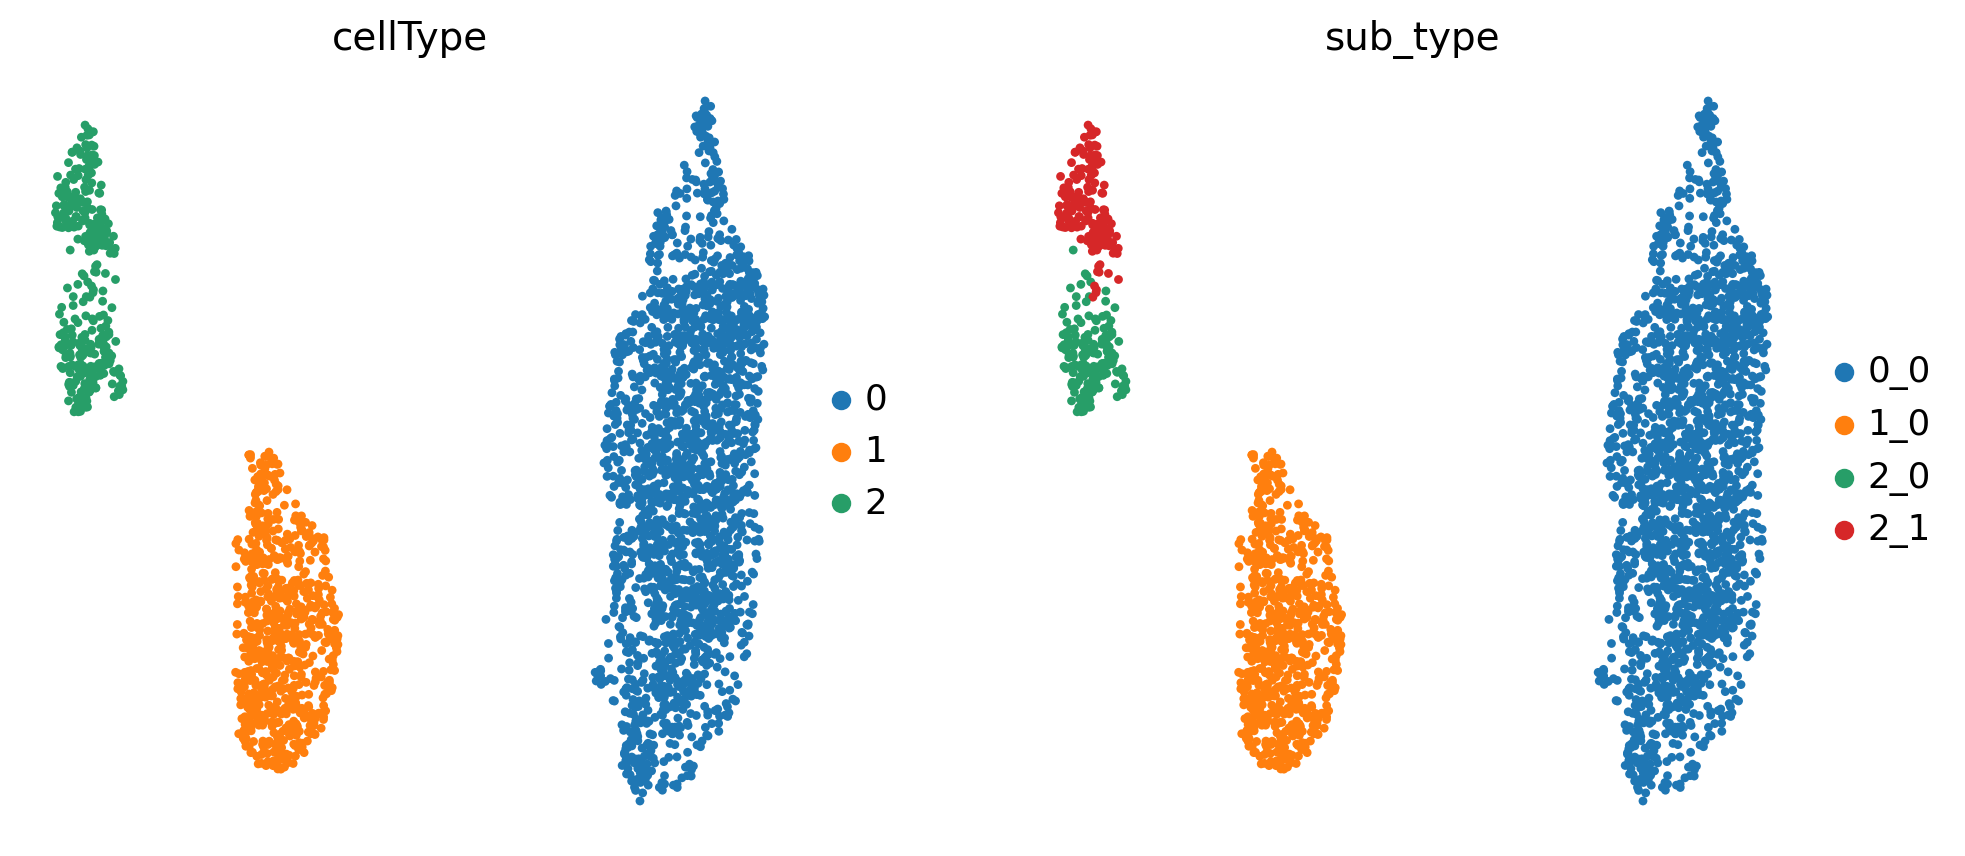

In [21]:
decon.sub_cluster(leiden_res=0.1)
dv.pl.umap_plot(decon, show=True, keys=[dv.params['cell_type_key'], "sub_type"])

/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/trimap/trimap_.py:747: UserWarning: 'weight_adj' is deprecated and will not be applied. Adjust 'weight_temp' if needed.
  warnings.warn(
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


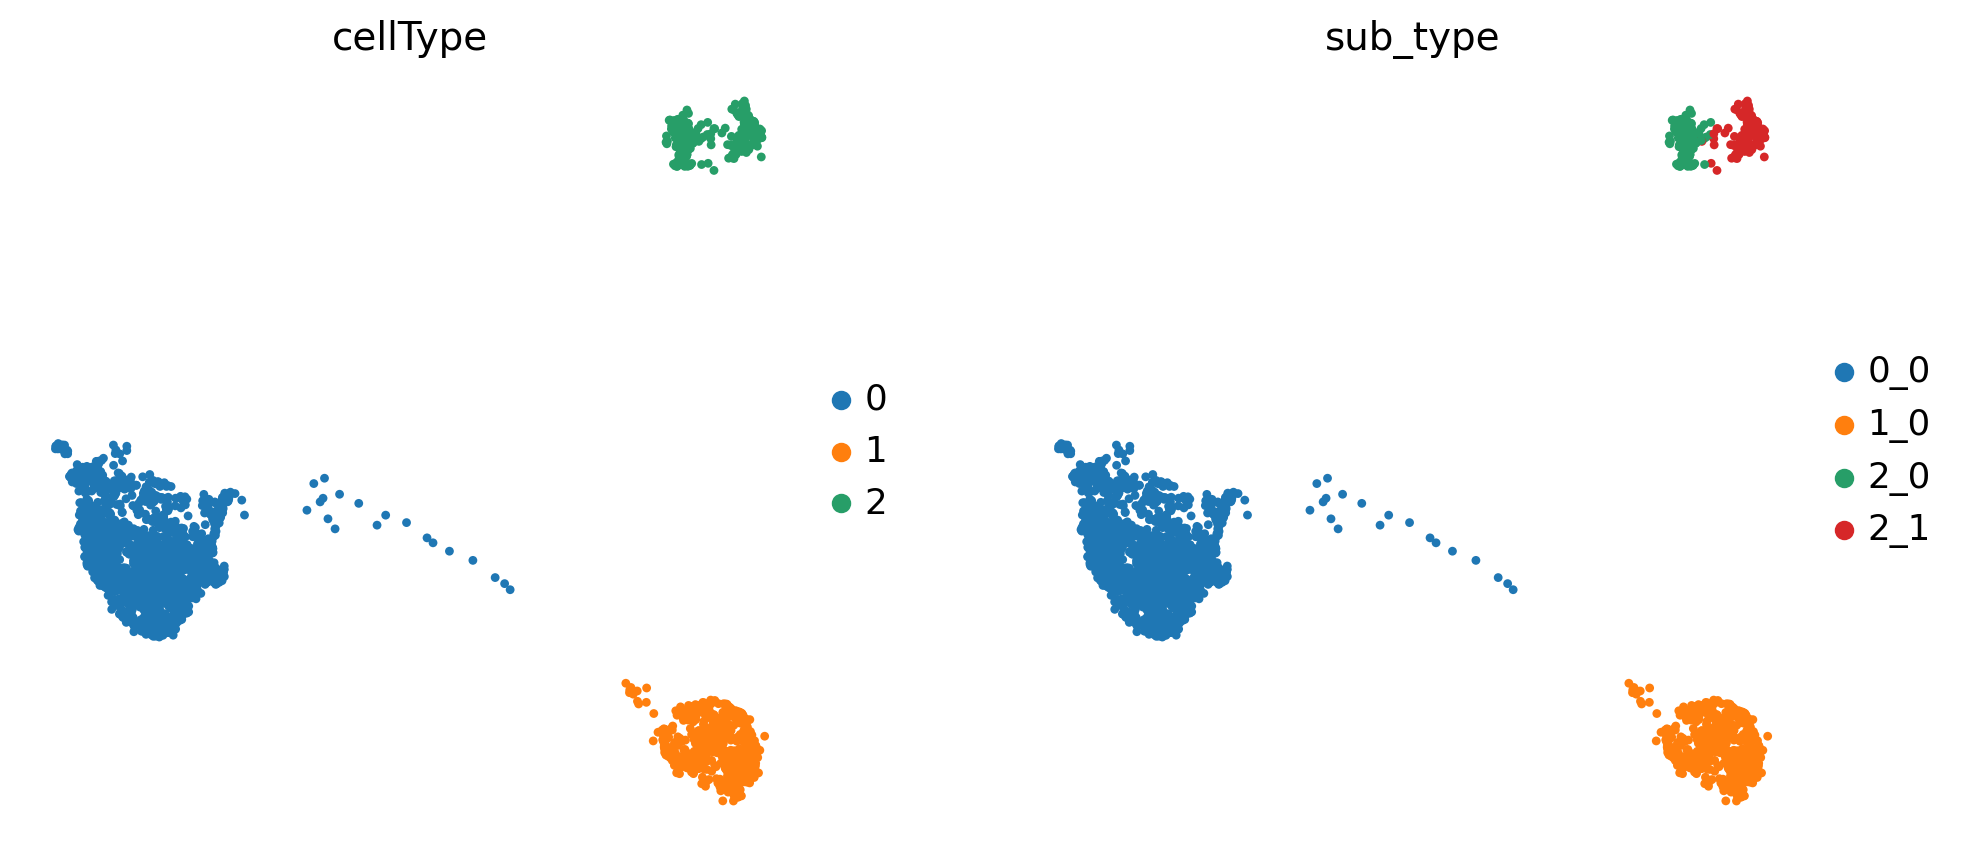

In [22]:
sc.external.tl.trimap(decon.sadata)
sc.external.pl.trimap(decon.sadata, color=[dv.params["cell_type_key"], "sub_type"], ncols=2, frameon=False)

In [24]:
scout.tl.rank_marker_genes(decon.sadata, groupby=decon.label_key)

/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [43]:
top_variable_genes = []
for i, cell_type in enumerate(decon.cell_types):
    top_variable_genes.extend(sadata.uns[f"rank_genes_{decon.label_key}"][cell_type].sort_values("gene_score").index[:10].tolist())

top_variable_genes = list(set(top_variable_genes))

In [44]:
scout.ply.heatmap(
    decon.sadata, top_variable_genes, categoricals=[decon.label_key], layout=dict(width=1200),
)

0.37380857420312785
[0, 0.18690428710156393, 0.37380857420312785, 0.3130957128984361, 1]


Using 319 cells from 3 cellTypes


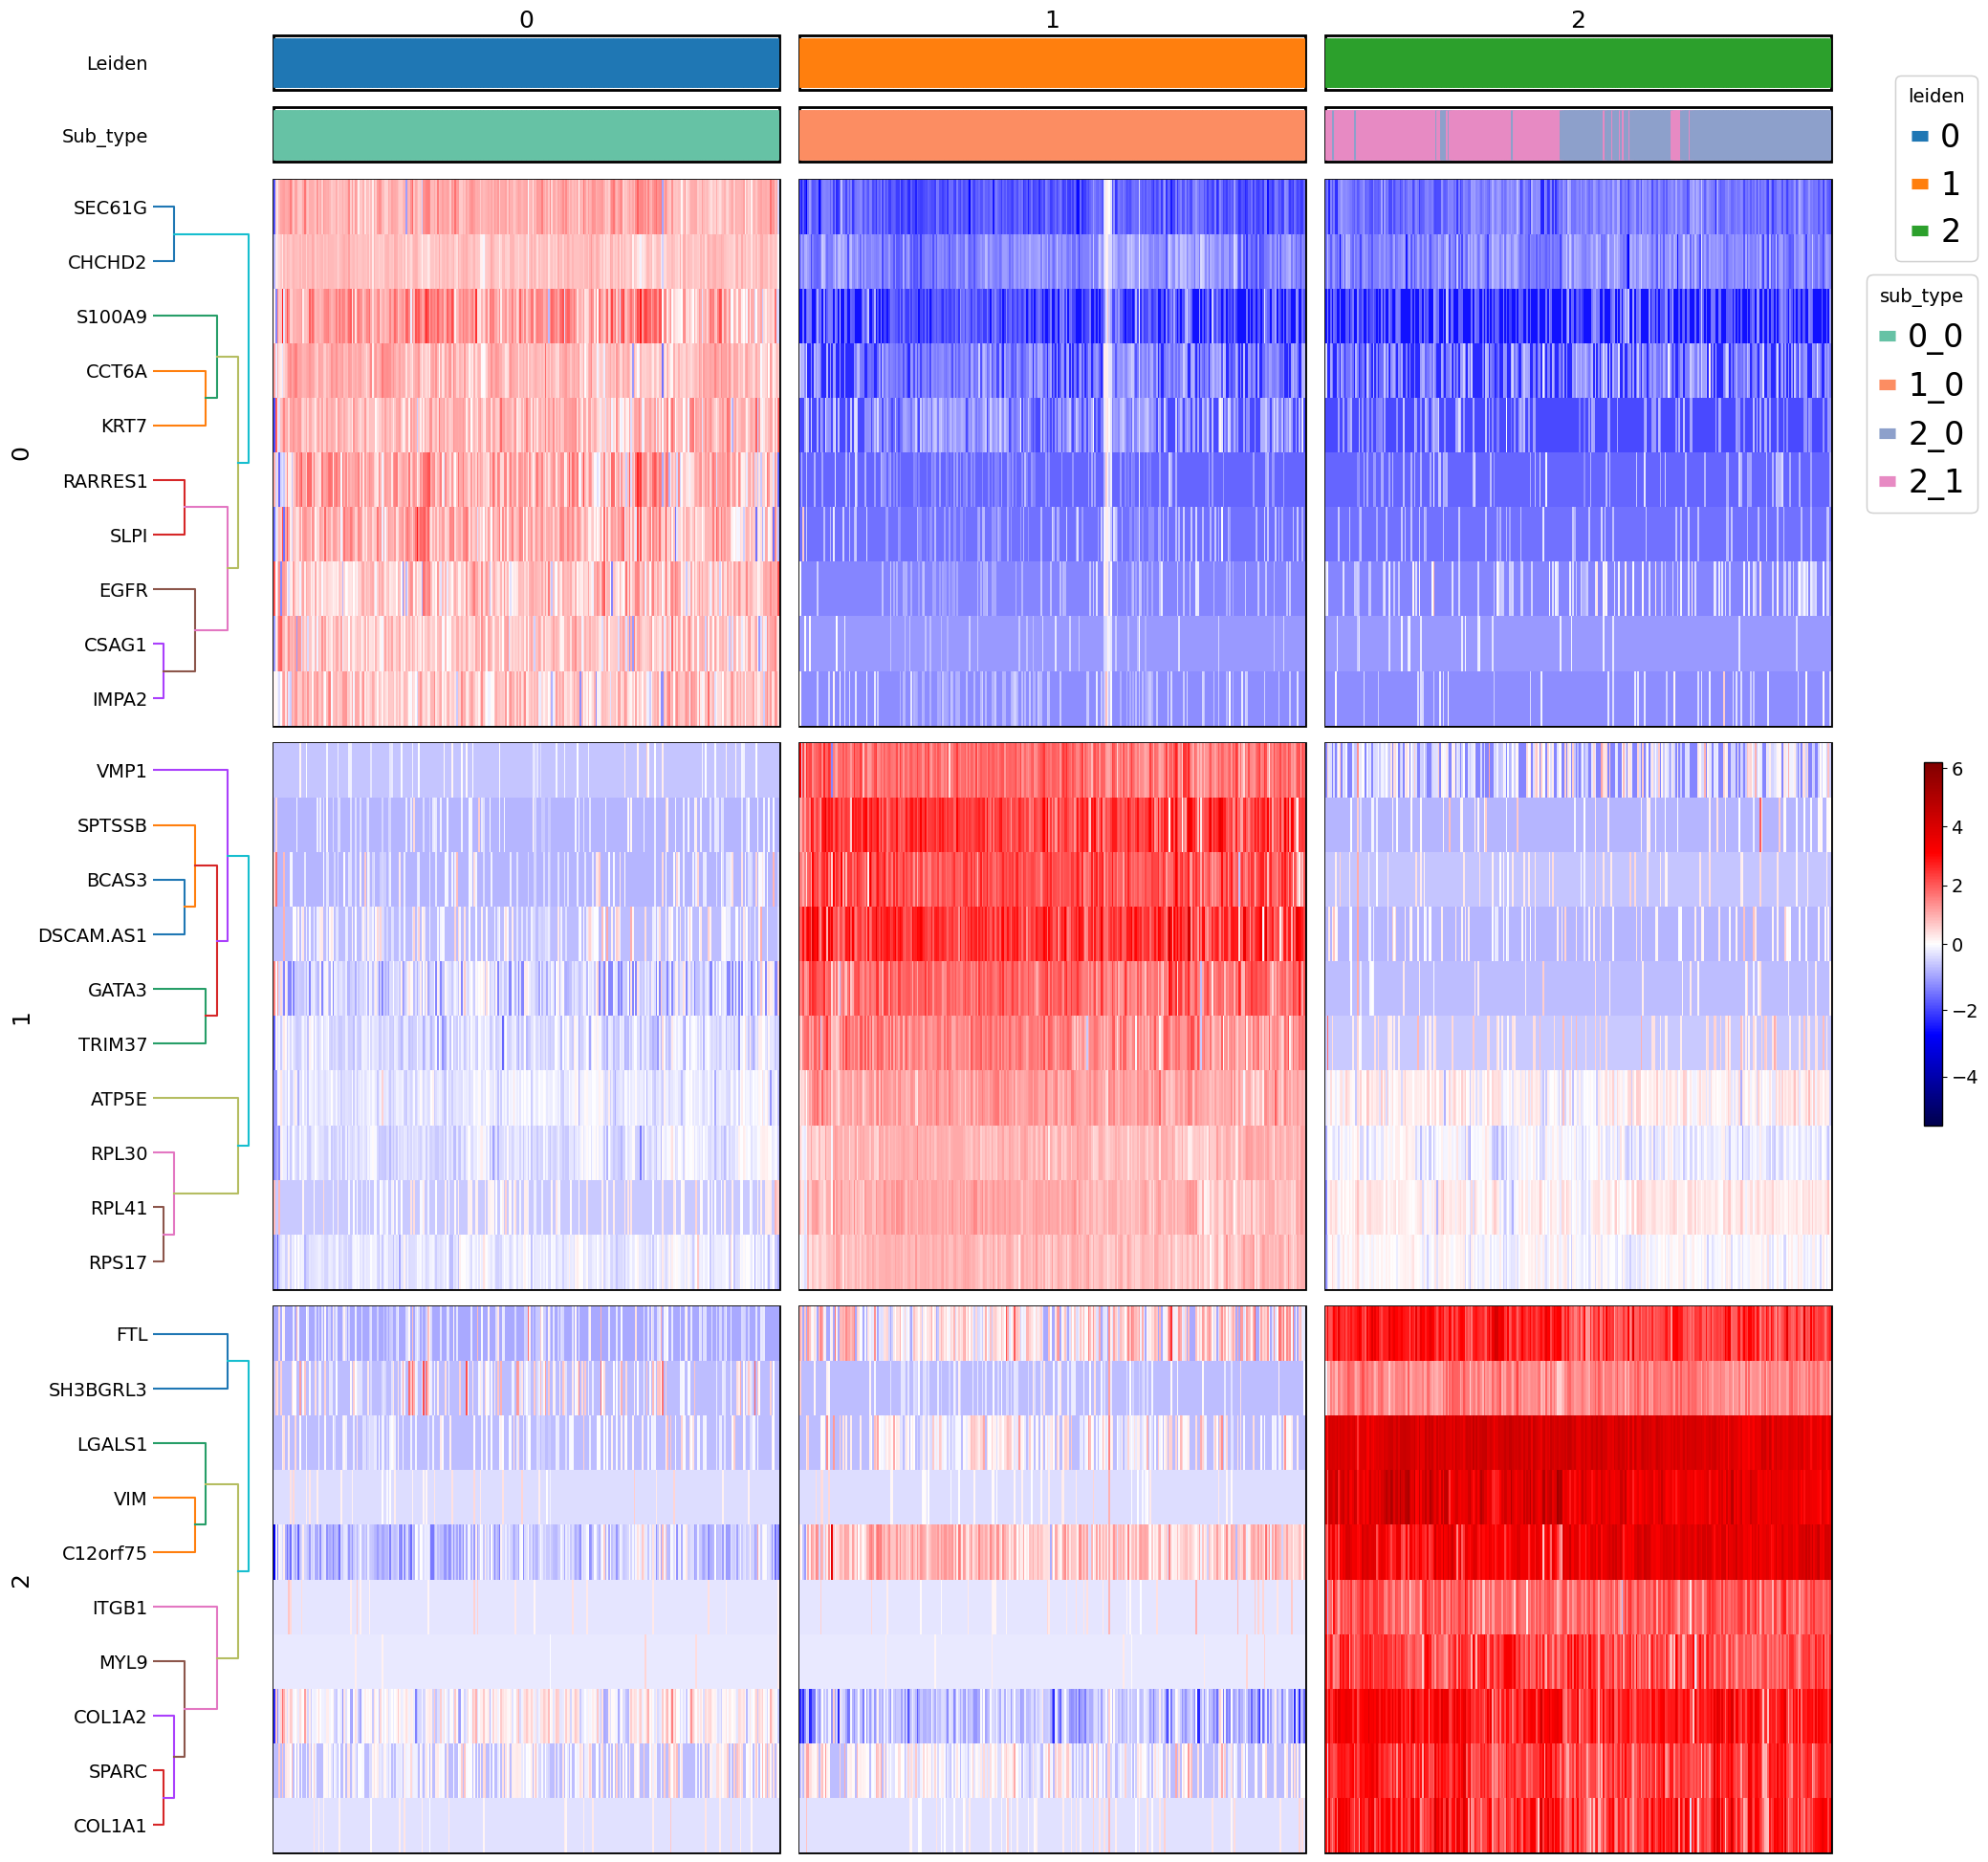

In [ ]:
dv.pl.clustermap(decon.sadata, clusterby="cellType", categorical_features=[decon.label_key, "sub_type"], min_cells=45)

In [ ]:
# decon.filter_outliers(dropout_mu_lim=2.5, dropout_lim=1.0, marker_zscore_lim=0.3, dispersion_lims=(-3, 1), pseudobulk_lims=(-8,8))
decon.filter_outliers()

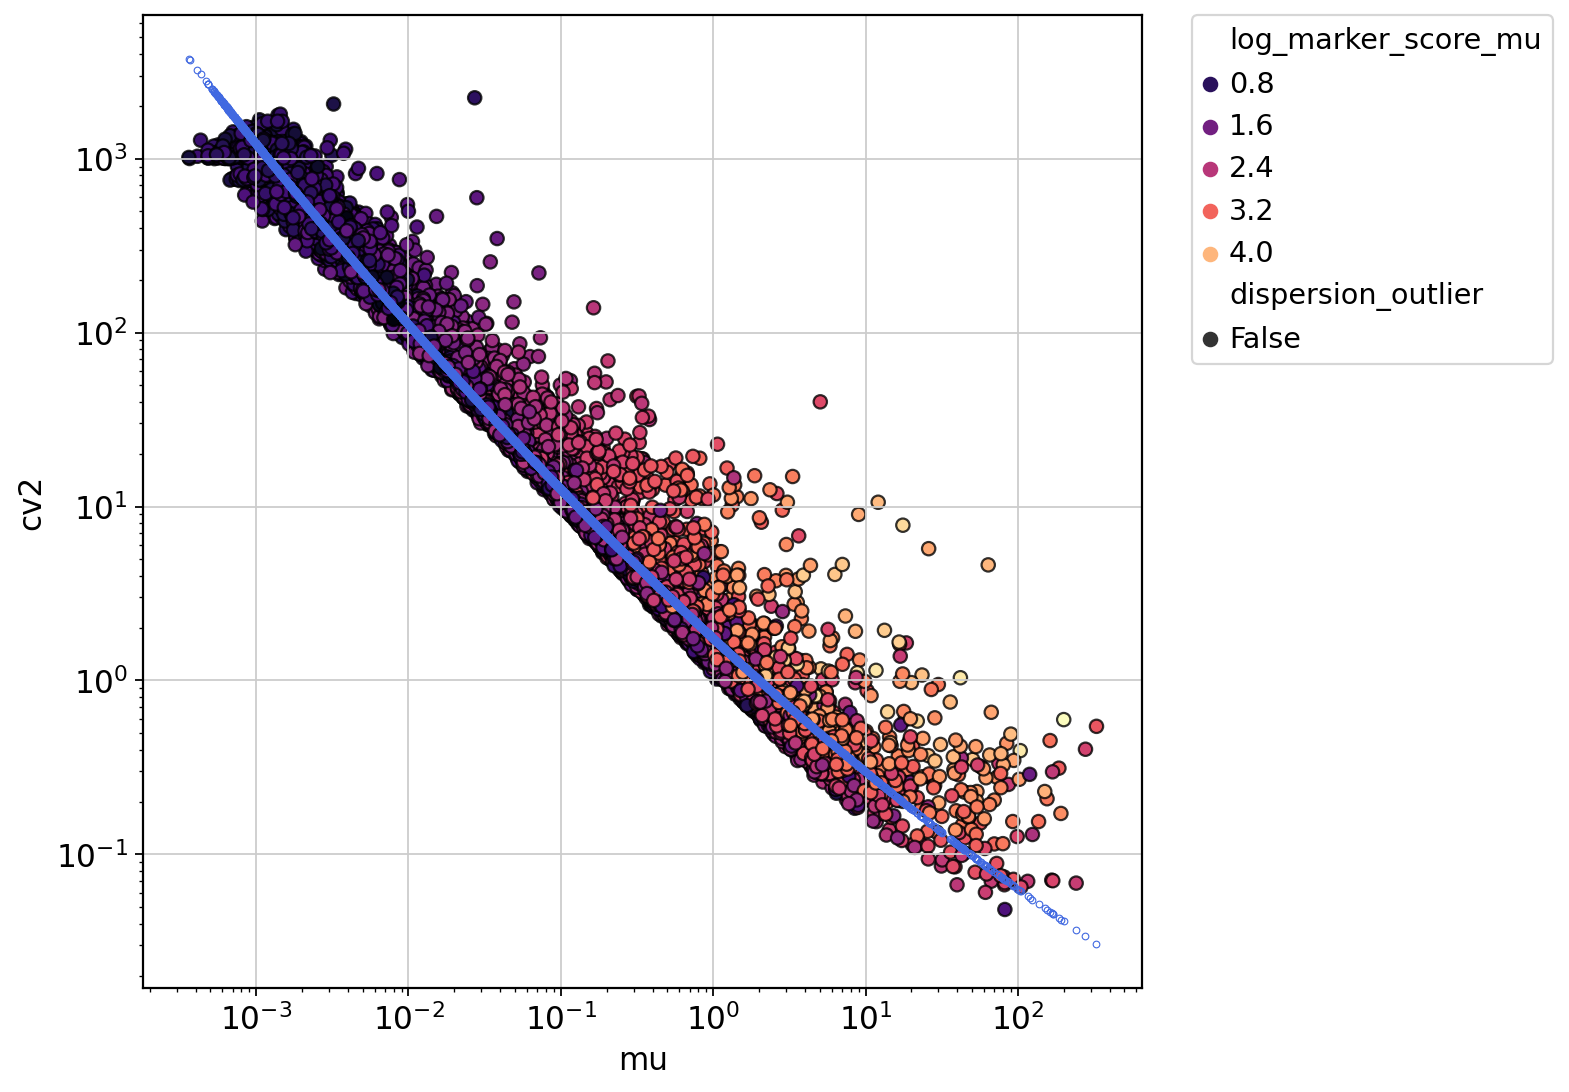

In [ ]:
pl.dispersion_plot(decon, hue="log_marker_score_mu", style="dispersion_outlier", figsize=(8,8), dpi=80, separate_ct=False, palette="magma")

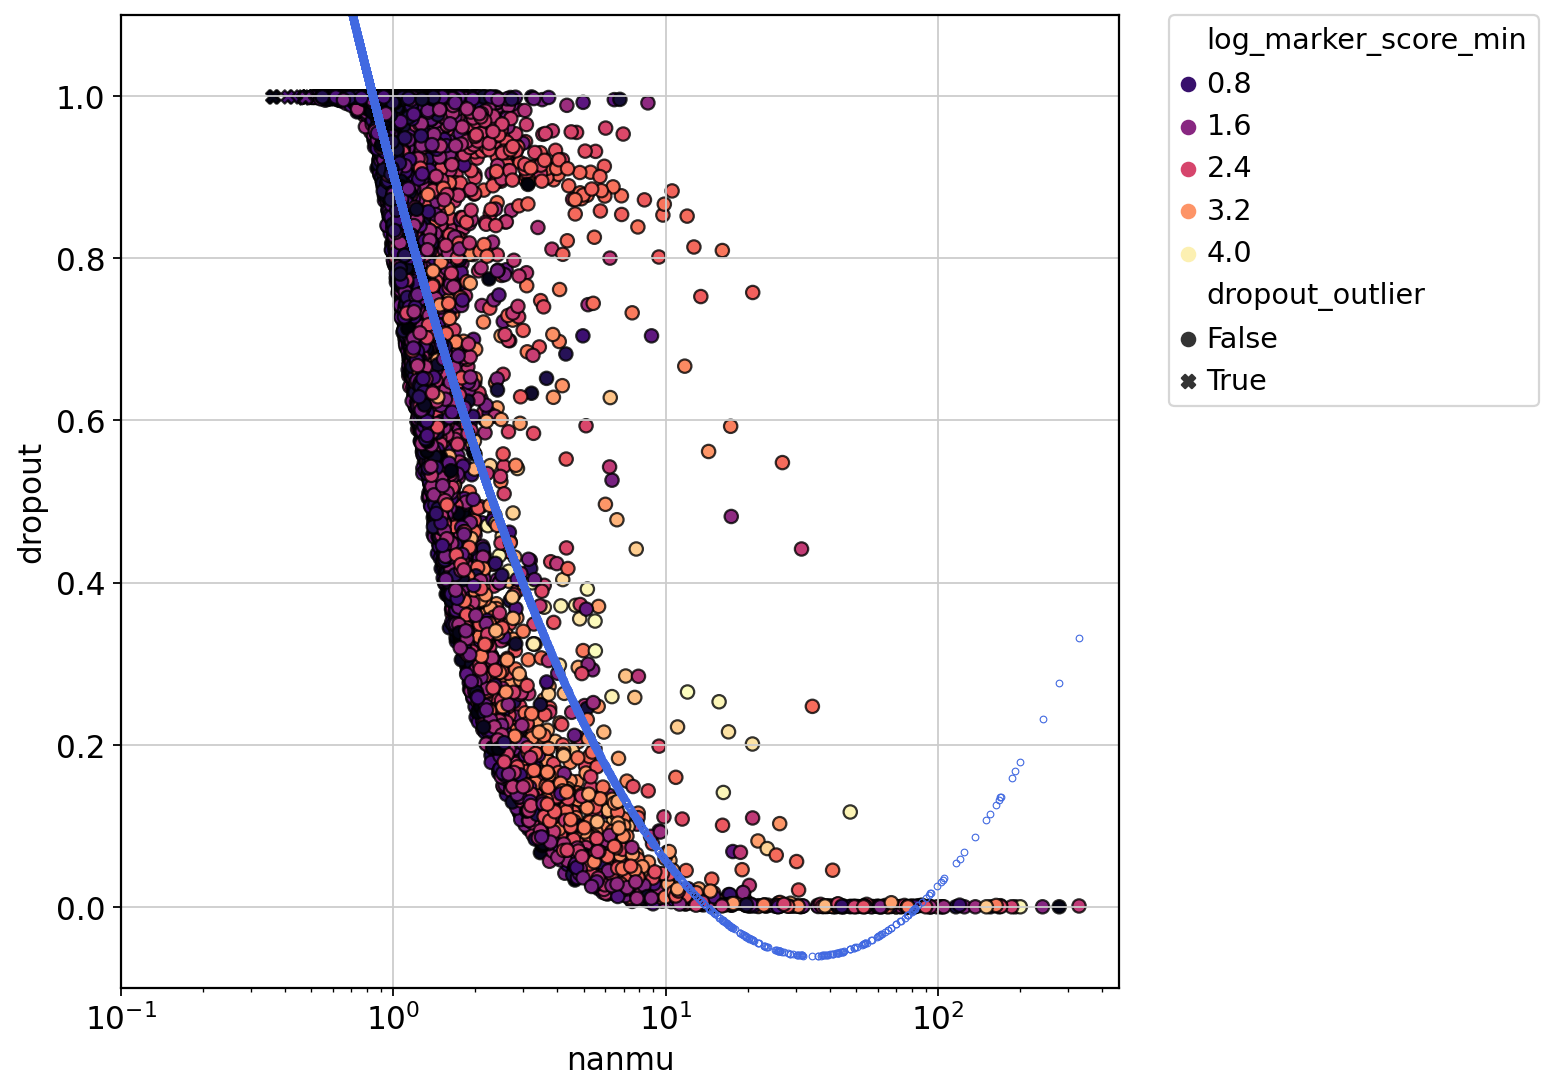

In [ ]:
pl.dropout_plot(decon, hue="log_marker_score_min", style="dropout_outlier", xlim=(0.1, None), dpi=80, separate_ct=False, palette="magma")

In [ ]:
# pl.pseudo_bulk_plot(
#     decon, hue="log_bulk_residual", style="pseudobulk_outlier", palette="magma"
# )

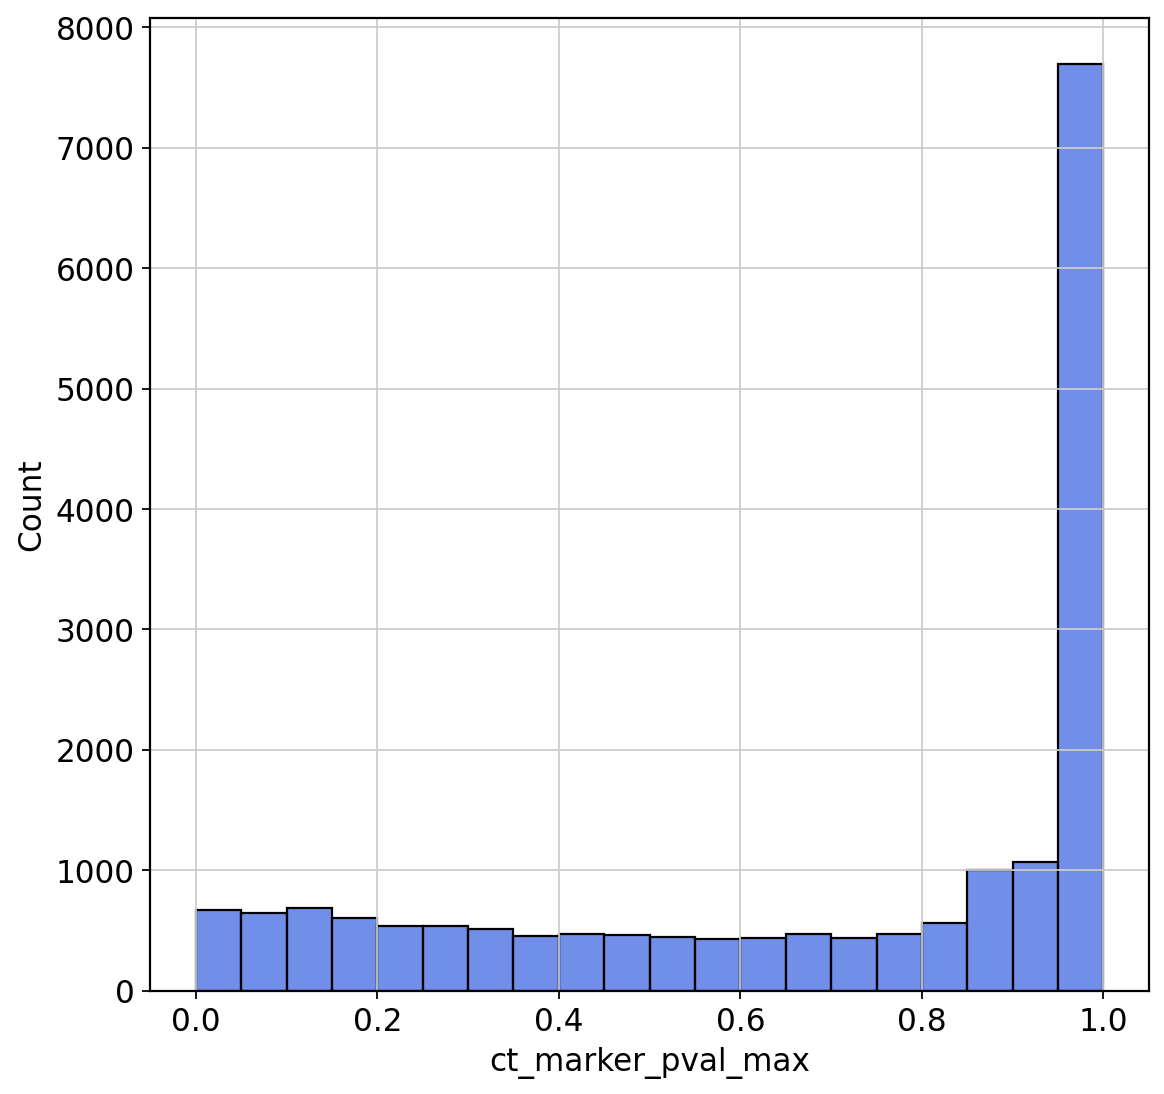

Creating signature for cell types: ['0', '2', '1']...


/home/lutrarutra/Documents/dev/fimm/deconv/core/deconV.py:274: RuntimeWarning: divide by zero encountered in true_divide
  self.normalising_constant = 1.0 / torch.tensor(np.nanmean(np.nan_to_num(self.sadata.layers["counts"].sum(0) / self.badata.layers["counts"], posinf=np.nan), axis=1))


In [ ]:
decon.init_dataset(use_outliers=False, gene_weight_key="ct_marker_pval_max")
decon.init_signature()

Sample: 0/1


100%|██████████| 5000/5000 [00:04<00:00, 1037.43it/s, loss=288437.8, props=0.62 0.19 0.19, lib_size=1507578.2]


Plotting results...


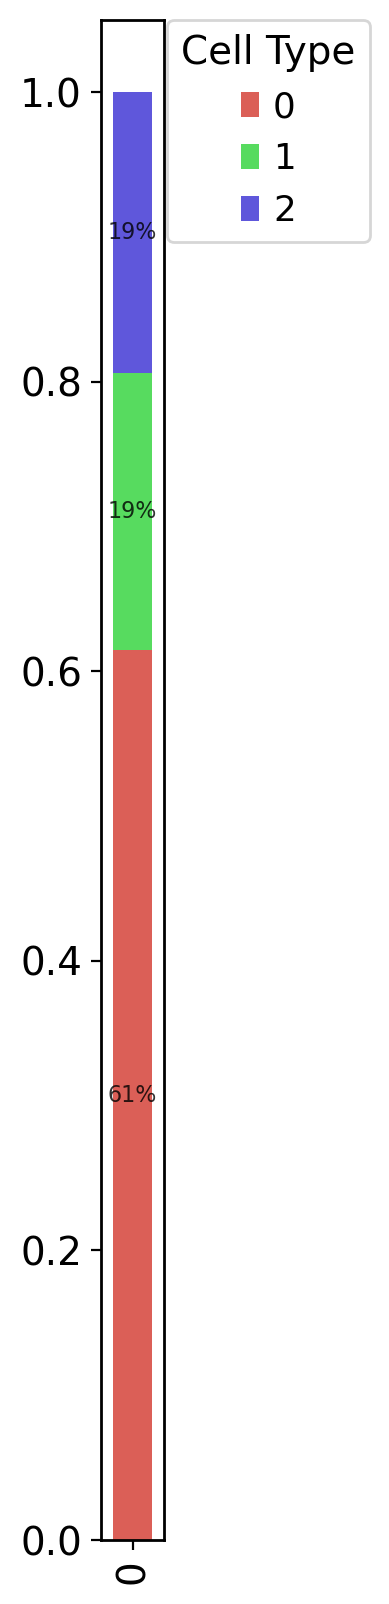

In [ ]:
est_df = decon.deconvolute()

In [ ]:
true_df = pd.read_csv("../../data/xin/true.tsv", "\t", index_col=0)

/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


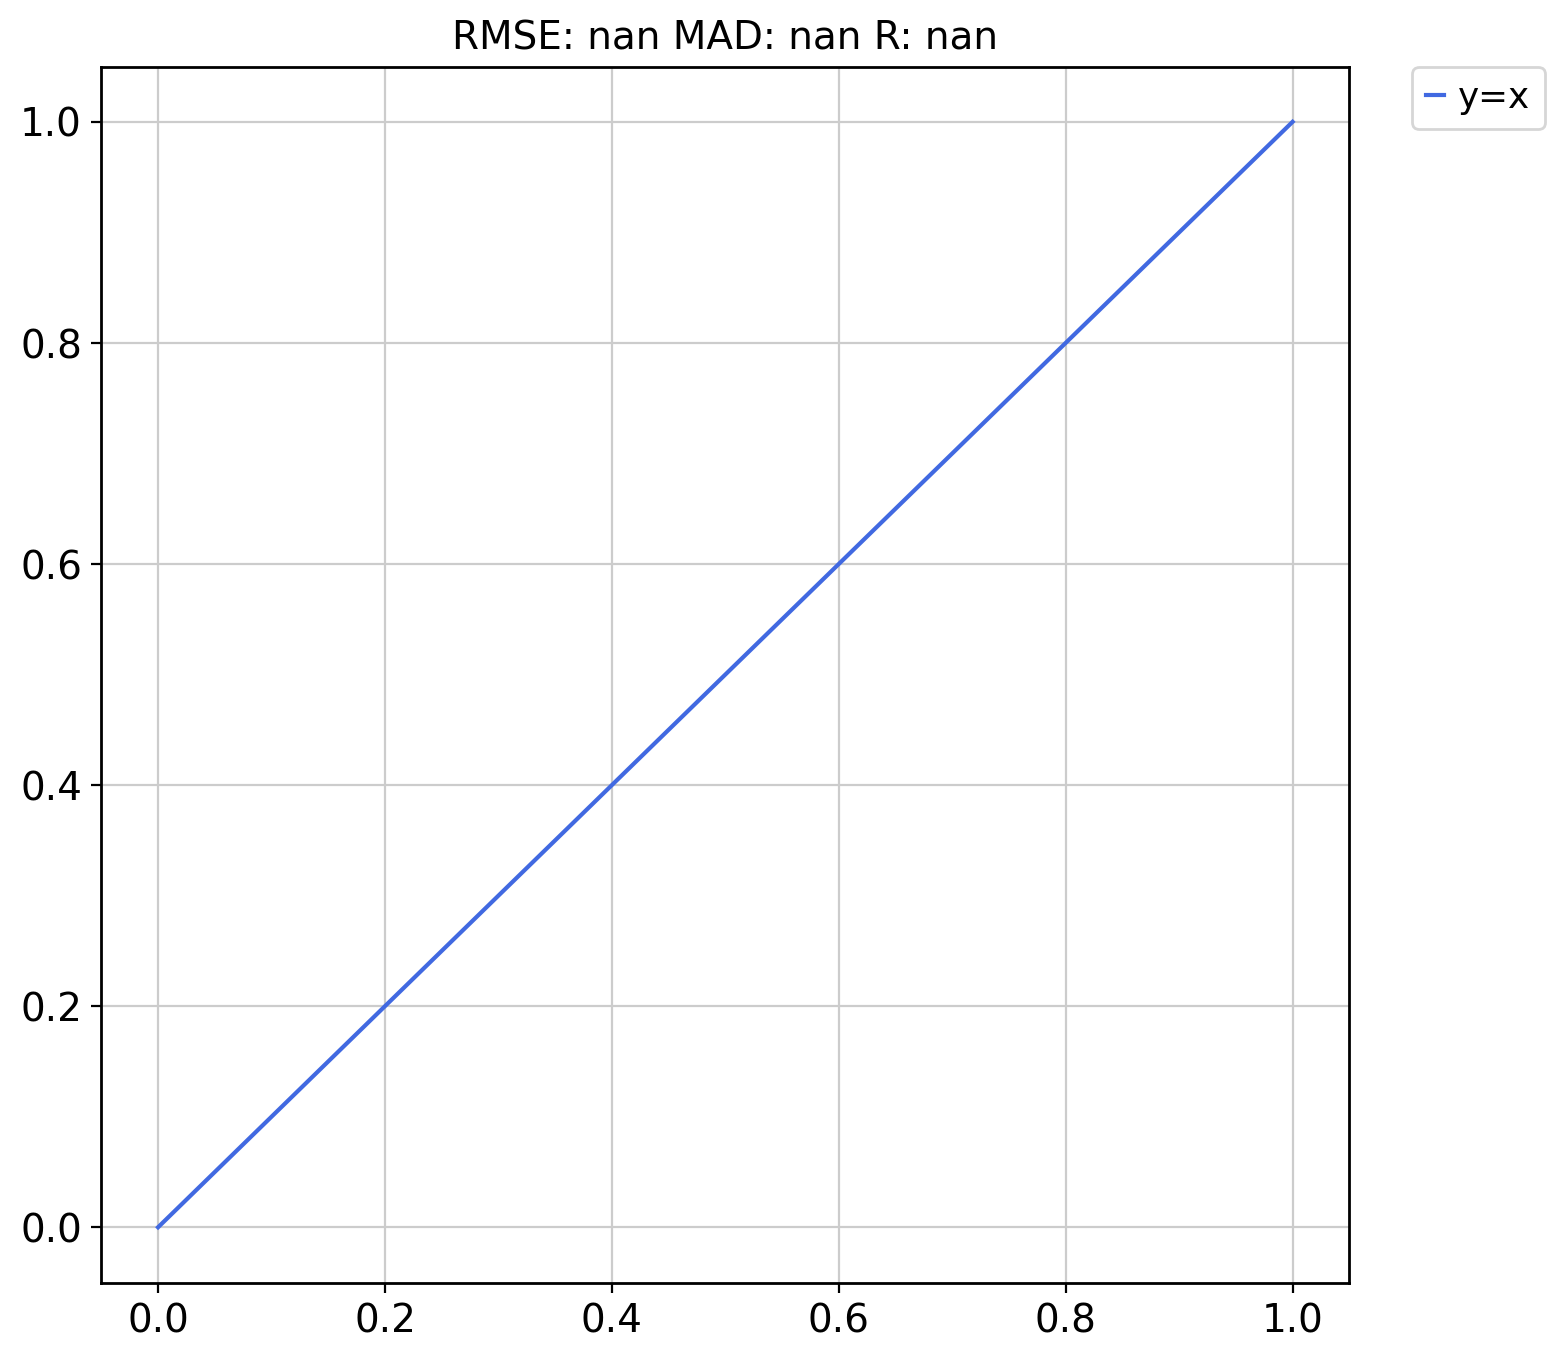

In [ ]:
pl.scatter_check(true_df, est_df, style="sample")